<a href="https://colab.research.google.com/github/carloslizarragac/CC_Sonora/blob/master/AnalisisClima1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Junio  12, 2021
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Para calcular las estacionalidad, tendencia y residuo 
import statsmodels.api as sm

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#!pip install climate-indices
#!pip install standard-precip


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# En esta celda se hacen todas las operaciones de preparar el DataFrame df_meteo
# 
# En esta nueva Jupyter Notebook, en una celda vamos a concentrar todas las operaciones
# de transformación del dataframe original df_dist

# ----- Datos de entrada
# Analizaremos los datos de Información Estadística Climatológica del Servico Meteorológico Nacional 
# de CONAGUA que podemos descargar del sitio:
# (https://smn.conagua.gob.mx/es/climatologia/informacion-climatologica/informacion-estadistica-climatologica) 

# Tomar la dirección URL del archivo en formato 'raw'

#url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/Mazatan_26052.txt'

#url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/SLRCRiito_26076.txt'
#url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/26072_PPenasco.txt'
#url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/Sonoita_26096.txt'
#url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/Altar_26206.txt'
#url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/26259_Imuris.txt'
#url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/26001_AguaPrieta.txt'
#url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/MagdalenaVivero_26160.txt'
#url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/MoctezumaTerapa_26251.txt'
#url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/CostaHMOMaCarmen_26196.txt'
url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/26139_HMO.txt'
#url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/SahuaripaGuisamopa_26263.txt'
#url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/26123_Yecora.txt'
#url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/Guaymas26292.txt'
#url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/CObregon_26018.txt'
#url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/26061_Navojoa.txt'
#url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/AlamosSanBernardo_26080.txt'

CityName = 'Hermosillo'

# Oceanic Niño Index 
url2 = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/detrend.nino34.txt'

# -------------------
# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['Fecha', 'Precip', 'Evap', 'Tmax', 'Tmin']
#my_cols2 = ['Año', 'Ene', 'Feb', 'Mar', 'Abr', 'May', 'jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
#my_cols2 = ['Año', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
my_cols2 = ['Año', 'Month', 'SST', 'SST_Adj', 'Anomal']

df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')
df_oni_dist = pd.read_csv(url2, names=my_cols2,  skiprows=1, sep='\s+', header=None, engine='python')
# Convertir a flotante
#df_oni_dist["Anomal"] = df_oni_dist.Anomal.astype(float)


# Hacemos una copia de trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()

# Reemplazamos los textos 'Nulo' por espacio en blanco ''
str_Nulo = 'Nulo'
df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()

# Pandas tiene la función pd.to_datetime que convierte una cadena en tipo datetime64[ns]
# Intentamos a ver si Python reconoce el formato en nuestro caso. 
# Agregamos la opción de que el primer dato es el día (dayfirst=True)
df_work2['Fecha']=pd.to_datetime(df_work2['Fecha'], dayfirst=True).copy()

# Buscamos ahora añadir dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.strftime(%b) para extraer el Año 
# y Mes (Abreviado) de la Fecha
df_work2['Año'] = df_work2['Fecha'].dt.year
df_work2['Month'] = df_work2['Fecha'].dt.month
df_work2['Mes'] = df_work2['Fecha'].dt.strftime('%b')

# Definimos un nuevo DataFrame para el análisis de los datos meteorológicos. 
# Será nuestro nuevo punto de partida.
df_meteo = df_work2.copy()

# Imprimimos y verificamos el rango de datos incluidos

print('Ciudad:', CityName)

df_meteo.info()

print(df_meteo.head())
print(df_meteo.tail())

print(df_oni_dist.head(15))


Ciudad: Hermosillo
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19301 entries, 0 to 19300
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   19301 non-null  datetime64[ns]
 1   Precip  19291 non-null  float64       
 2   Evap    10285 non-null  float64       
 3   Tmax    19121 non-null  float64       
 4   Tmin    19138 non-null  float64       
 5   Año     19301 non-null  int64         
 6   Month   19301 non-null  int64         
 7   Mes     19301 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 1.2+ MB
       Fecha  Precip  Evap  Tmax  Tmin   Año  Month  Mes
0 1961-01-01     0.0   1.6  23.0   7.0  1961      1  Jan
1 1961-01-02     0.0   2.1  25.0   5.0  1961      1  Jan
2 1961-01-03     0.0   4.5  26.0   7.0  1961      1  Jan
3 1961-01-04     0.0   2.5  26.5   8.0  1961      1  Jan
4 1961-01-05    20.0   4.6  27.0   7.5  1961      1  Jan
          

In [ ]:
df_oni_dist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857 entries, 0 to 856
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Año      857 non-null    int64  
 1   Month    857 non-null    int64  
 2   SST      857 non-null    float64
 3   SST_Adj  857 non-null    float64
 4   Anomal   857 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 33.6 KB


In [ ]:
#Si se quiere una serie de tiempo hacemos esto

# Hacemos una copia del último DataFrame para realizar nuevas operaciones
#df_meteo_ts = df_meteo.copy()
# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
#df_meteo_ts = df_meteo_ts.set_index('Fecha')

# Verificamos
#df_meteo_ts.info()
#print(df_meteo_ts.head())
#print(df_meteo_ts.tail())


## Selección del periodo de 30 años (1981-2010)

In [ ]:
# Seleccionaremos un conjunto de años de 30 años  

# Para este caso los datos de 2017 están incompletos. Lo excluimos.
#df_31 = df_meteo[(df_meteo['Año'] >= 1931) & (df_meteo['Año'] < 1961)]
#df_61 = df_meteo[(df_meteo['Año'] >= 1961) & (df_meteo['Año'] < 1991)]
#df_91 = df_meteo[(df_meteo['Año'] >= 1991) & (df_meteo['Año'] < 2016)]

df_81 = df_meteo[(df_meteo['Año'] >= 1981) & (df_meteo['Año'] < 2011)]
df_oni = df_oni_dist[(df_oni_dist['Año'] >= 1981) & (df_oni_dist['Año'] < 2011)]

# Agregamos una columna con el día Juliano 
df_81['DiaJuliano'] = df_81['Fecha'].dt.strftime('%Y%j')

# Definimos un dataframe con la precipitación mensual acumulada por año
df_Precip=df_81.groupby(['Año', 'Month'], as_index=False)['Precip'].sum()

# Definimos el Periodo de Años de datos

Period = '1981-2010'


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [ ]:
print(df_81.describe())
print(df_81.head())
print(df_81.tail())


             Precip         Evap  ...           Año         Month
count  10932.000000  4993.000000  ...  10941.000000  10941.000000
mean       1.061553     7.437893  ...   1995.497487      6.526552
std        5.874470     3.415683  ...      8.661337      3.449896
min        0.000000     0.100000  ...   1981.000000      1.000000
25%        0.000000     4.700000  ...   1988.000000      4.000000
50%        0.000000     7.200000  ...   1995.000000      7.000000
75%        0.000000    10.000000  ...   2003.000000     10.000000
max      152.600000    18.000000  ...   2010.000000     12.000000

[8 rows x 6 columns]
          Fecha  Precip  Evap  Tmax  Tmin   Año  Month  Mes DiaJuliano
5743 1981-01-01     0.0   4.1  29.0  13.0  1981      1  Jan    1981001
5744 1981-01-02     0.0   5.2  27.5  12.5  1981      1  Jan    1981002
5745 1981-01-03     0.0   3.7  30.0  12.0  1981      1  Jan    1981003
5746 1981-01-04     0.0   5.3  30.0  14.5  1981      1  Jan    1981004
5747 1981-01-05     0.1   3.5

In [ ]:
df_oni


,Año,Month,SST,SST_Adj,Anomal
372,1981,1,26.19,26.57,-0.38
373,1981,2,26.12,26.75,-0.62
374,1981,3,26.66,27.17,-0.51
375,1981,4,27.30,27.59,-0.29
376,1981,5,27.36,27.66,-0.30
...,...,...,...,...,...
727,2010,8,25.47,26.86,-1.38
728,2010,9,25.12,26.72,-1.59
729,2010,10,25.03,26.72,-1.69
730,2010,11,25.06,26.70,-1.64


In [ ]:
# Merge 2 dataframes
df_precip_merged = pd.merge(df_Precip, df_oni, on=["Año", "Month"])
df_precip_merged.head(10)


,Año,Month,Precip,SST,SST_Adj,Anomal
0,1981,1,53.5,26.19,26.57,-0.38
1,1981,2,5.8,26.12,26.75,-0.62
2,1981,3,14.5,26.66,27.17,-0.51
3,1981,4,5.2,27.30,27.59,-0.29
4,1981,5,8.4,27.36,27.66,-0.30
5,1981,6,1.8,27.27,27.46,-0.19
6,1981,7,120.5,26.65,27.02,-0.37
7,1981,8,7.2,26.32,26.64,-0.32
8,1981,9,53.6,26.52,26.56,-0.04
9,1981,10,13.9,26.42,26.53,-0.11


In [ ]:
P_star= np.mean(df_precip_merged.Precip)
sigmaP = np.std(df_precip_merged.Precip)
print(P_star, sigmaP)


32.235833333333325 47.293072893923906


In [ ]:
df_precip_merged['P_anomal'] = (df_precip_merged['Precip']-P_star)/sigmaP
df_precip_merged.head(10)


,Año,Month,Precip,SST,SST_Adj,Anomal,P_anomal
0,1981,1,53.5,26.19,26.57,-0.38,0.449625
1,1981,2,5.8,26.12,26.75,-0.62,-0.558979
2,1981,3,14.5,26.66,27.17,-0.51,-0.375020
3,1981,4,5.2,27.30,27.59,-0.29,-0.571666
4,1981,5,8.4,27.36,27.66,-0.30,-0.504003
5,1981,6,1.8,27.27,27.46,-0.19,-0.643558
6,1981,7,120.5,26.65,27.02,-0.37,1.866323
7,1981,8,7.2,26.32,26.64,-0.32,-0.529376
8,1981,9,53.6,26.52,26.56,-0.04,0.451740
9,1981,10,13.9,26.42,26.53,-0.11,-0.387707


In [ ]:
df_precip_merged['Fecha'] = df_precip_merged['Año'].astype(str) + '-' + df_precip_merged['Month'].astype(str)
df_precip_merged.head(10)


,Año,Month,Precip,SST,SST_Adj,Anomal,P_anomal,Fecha
0,1981,1,53.5,26.19,26.57,-0.38,0.449625,1981-1
1,1981,2,5.8,26.12,26.75,-0.62,-0.558979,1981-2
2,1981,3,14.5,26.66,27.17,-0.51,-0.375020,1981-3
3,1981,4,5.2,27.30,27.59,-0.29,-0.571666,1981-4
4,1981,5,8.4,27.36,27.66,-0.30,-0.504003,1981-5
5,1981,6,1.8,27.27,27.46,-0.19,-0.643558,1981-6
6,1981,7,120.5,26.65,27.02,-0.37,1.866323,1981-7
7,1981,8,7.2,26.32,26.64,-0.32,-0.529376,1981-8
8,1981,9,53.6,26.52,26.56,-0.04,0.451740,1981-9
9,1981,10,13.9,26.42,26.53,-0.11,-0.387707,1981-10


In [ ]:
df_precip_merged.describe()


,Año,Month,Precip,SST,SST_Adj,Anomal,P_anomal
count,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,3.600000e+02
mean,1995.500000,6.500000,32.235833,27.023194,27.004444,0.018667,2.097088e-16
std,8.667488,3.456857,47.358895,1.007146,0.453233,0.899707,1.001392e+00
min,1981.000000,1.000000,0.000000,24.590000,26.450000,-1.870000,-6.816185e-01
25%,1988.000000,3.750000,0.000000,26.320000,26.647500,-0.602500,-6.816185e-01
50%,1995.500000,6.500000,9.000000,27.075000,26.785000,-0.045000,-4.913158e-01
75%,2003.000000,9.250000,46.900000,27.722500,27.325000,0.570000,3.100701e-01
max,2010.000000,12.000000,239.200000,29.110000,27.940000,2.480000,4.376205e+00


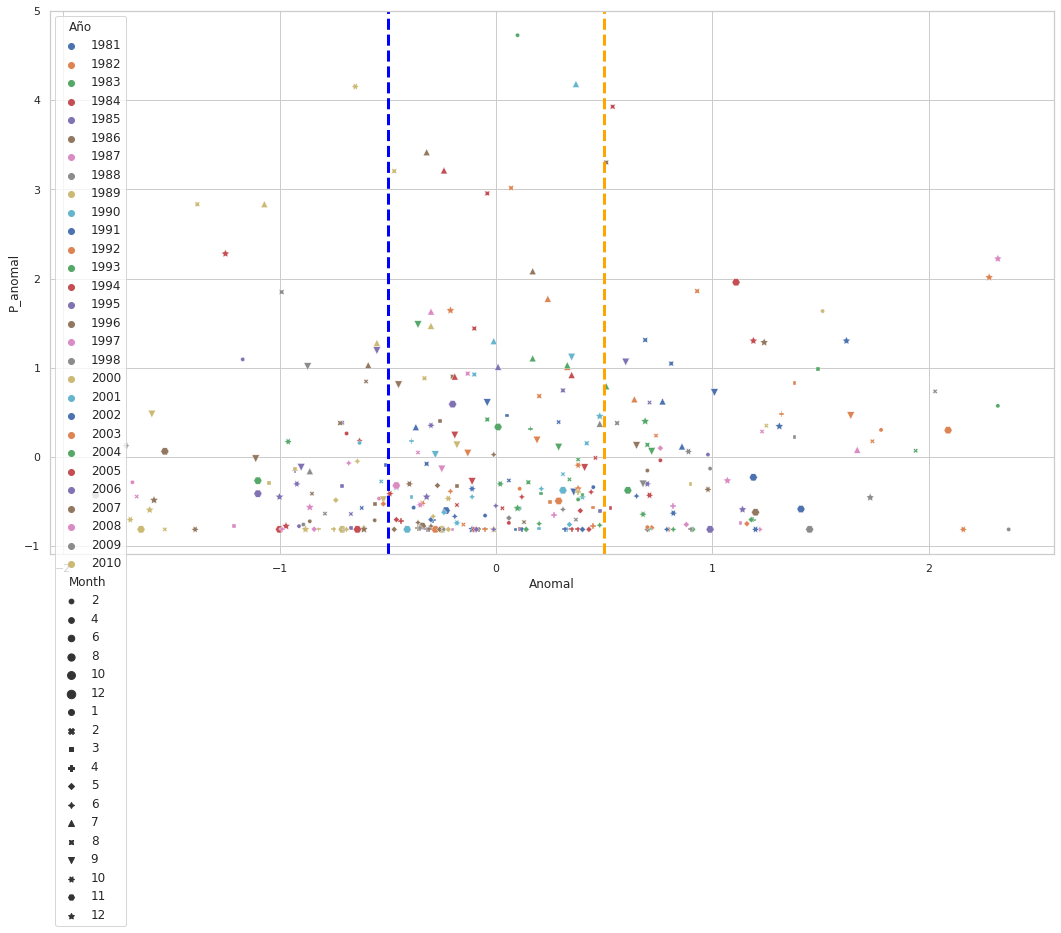

In [ ]:
sns.set(style='whitegrid')
plt.figure(figsize=(18,10))

sns.scatterplot(x="Anomal",
                    y="P_anomal",
                    style="Month",
                    hue='Año',
                    size='Month',
                    palette='deep',
                    data=df_precip_merged)
plt.axvline(-0.5, linewidth=3.0, color='blue', linestyle='--')
plt.axvline(0.5, linewidth=3.0, color='orange', linestyle='--')


In [ ]:
def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x, y, data=data, size = 8, legend=False)
    # Add text besides each point
    for line in range(0,data.shape[0]):
         p1.text(data[x][line]+0.01, data[y][line], 
                 data[text_column][line], horizontalalignment='left', 
                 size='large', color='black')
    # Set title and axis labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return p1


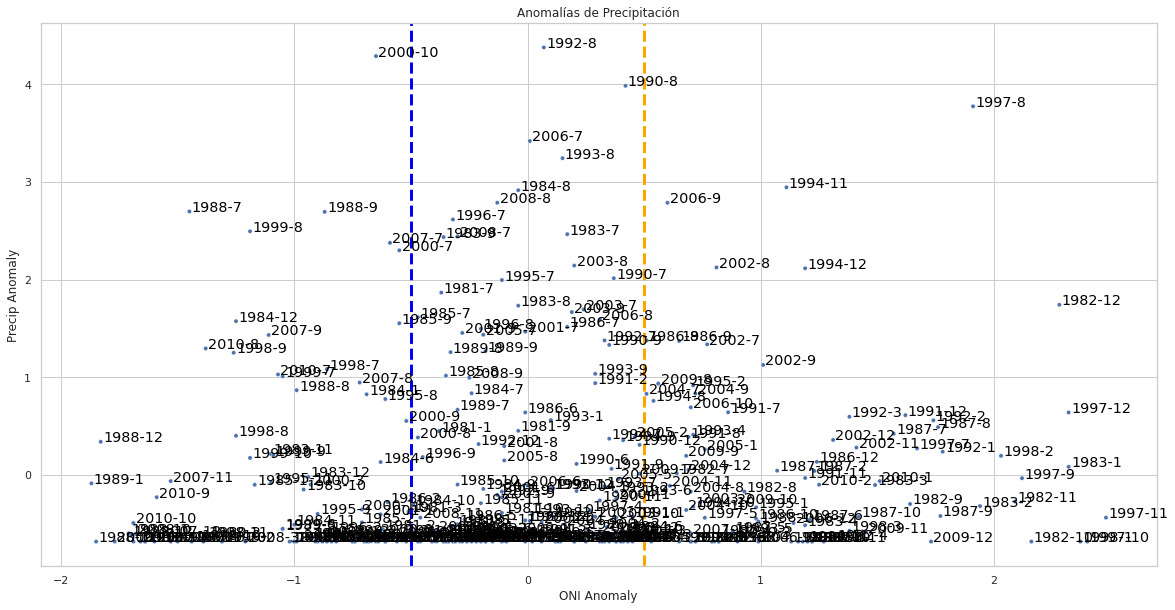

In [ ]:

sns.set(style='whitegrid')

plt.figure(figsize=(20,10))
scatter_text('Anomal', 'P_anomal', 'Fecha',
             data = df_precip_merged, 
             title = 'Anomalías de Precipitación', 
             xlabel = 'ONI Anomaly',
             ylabel = 'Precip Anomaly')
plt.axvline(-0.5, linewidth=3.0, color='blue', linestyle='--')
plt.axvline(0.5, linewidth=3.0, color='orange', linestyle='--')


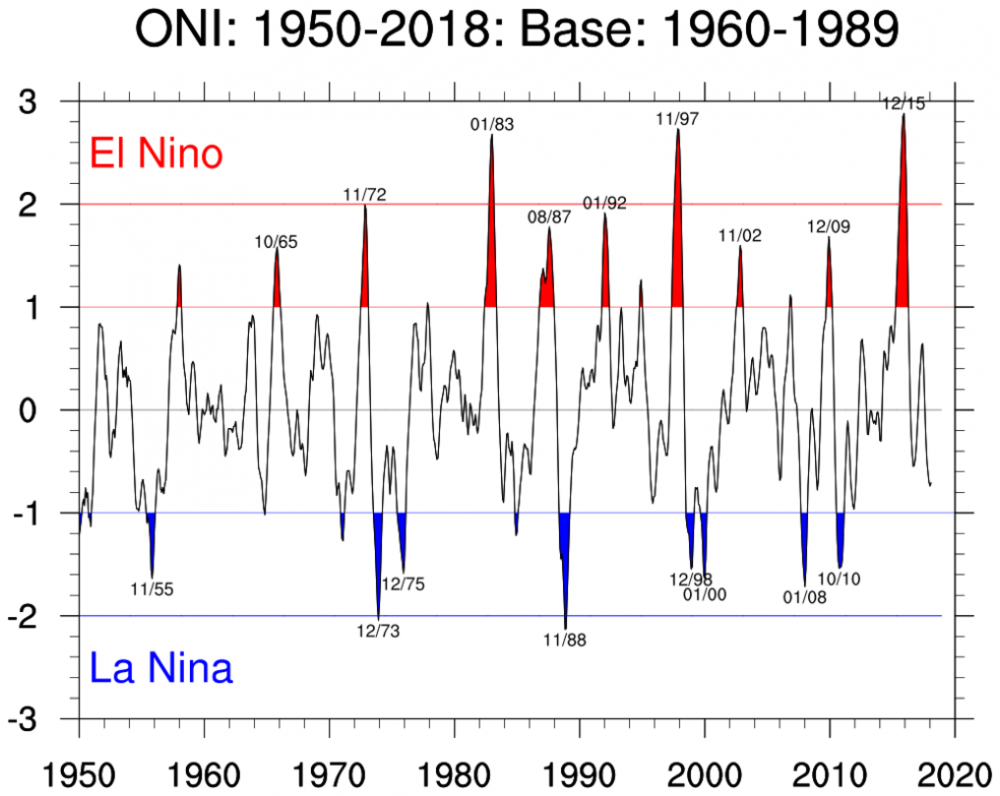

## Precipitación 

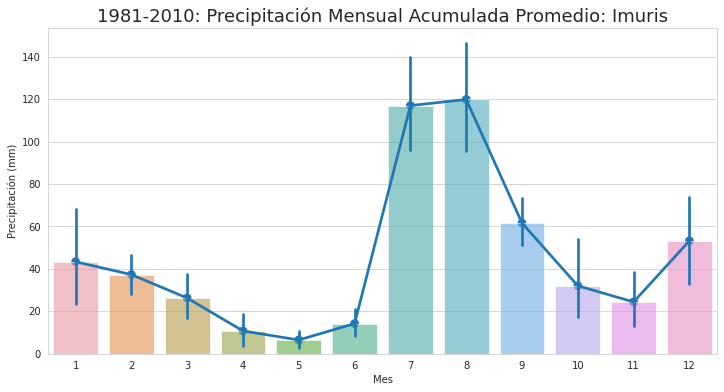

In [ ]:
# Gráfica de Precipitación últimos 30 años
# Agrupado por Mes
sns.set_style('whitegrid')
plt.figure(figsize=(12,6))


#
sns.pointplot(x='Month', y='Precip',  linewidth = 3.0, marker='o', data=df_Precip)
sns.barplot(x='Month', y='Precip', ci=None, data=df_Precip, alpha=0.6);
#sns.lineplot('Month', 'Precip', linewidth = 3.0, marker='o', data=df_Precip)


# Rotamos 45º los Años en el eje x para mejor lectura
#g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right');
#g.set_xlim(0,12)
plt.xlabel('Mes')
plt.ylabel('Precipitación (mm)')
plt.title(Period+': Precipitación Mensual Acumulada Promedio: '+ CityName, fontsize=18)

plt.show()


In [ ]:
# Precipitación anual acumulada por año 

List_Yr = df_81['Año'].unique()

Precip_Total = pd.DataFrame(columns=['Año', 'Precip_tot'])

for yr in List_Yr:
    cum_sum=df_81.Precip.loc[(df_81['Año'] == yr)].sum();
    Precip_Total = Precip_Total.append({'Año': yr, 'Precip_tot': cum_sum}, ignore_index=True);
    
print(Precip_Total)


       Año  Precip_tot
0   1981.0       303.4
1   1982.0       560.6
2   1983.0       617.8
3   1984.0       816.7
4   1985.0       478.4
5   1986.0       822.4
6   1987.0       111.7
7   1988.0       362.1
8   1989.0       326.7
9   1990.0       622.1
10  1991.0       531.0
11  1992.0       787.5
12  1993.0       655.2
13  1994.0       722.4
14  1995.0       243.3
15  1996.0       490.5
16  1997.0       340.8
17  1998.0       177.7
18  2000.0       722.6
19  2001.0       474.8
20  2002.0       379.4
21  2003.0       472.6
22  2004.0       424.4
23  2005.0       380.1
24  2006.0       381.3
25  2007.0       347.5
26  2008.0       415.0
27  2009.0       258.9
28  2010.0       738.2


In [ ]:
print('Precipitación acumulada anual promedio ',CityName,': ' ,Precip_Total.mean()[1])


Precipitación acumulada anual promedio  Imuris :  481.55517241379306


Precipitación Anual Promedio =  481.55517241379306 (mm)


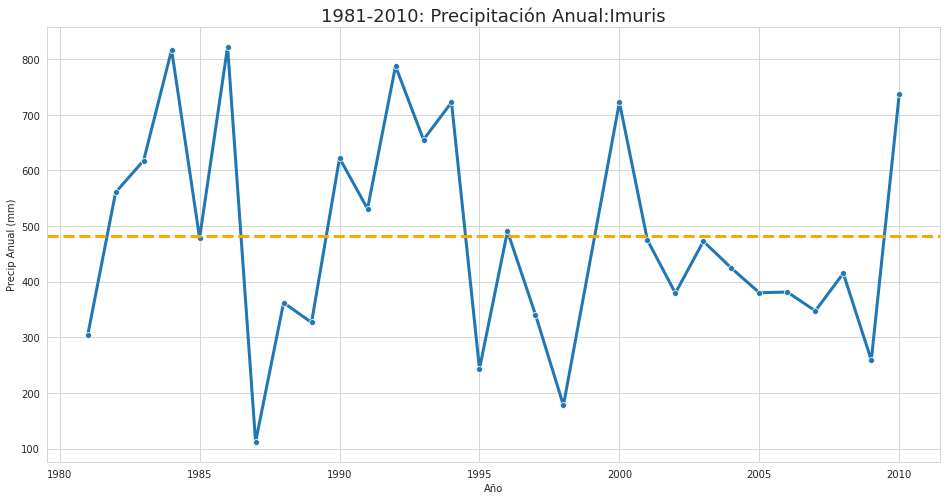

In [ ]:
# Precipitación Anual 

sns.set_style('whitegrid')
plt.figure(figsize=(16,8))

Precip_Anual_Prom = Precip_Total.mean()[1]
print('Precipitación Anual Promedio = ', Precip_Anual_Prom, '(mm)')

sns.lineplot('Año','Precip_tot', linewidth = 3.0, marker='o', data=Precip_Total)
plt.axhline(Precip_Anual_Prom, linewidth=3.0, color='orange', linestyle='--')
plt.xlabel('Año')
plt.ylabel('Precip Anual (mm)')
plt.title(Period+': Precipitación Anual:' + CityName, fontsize=18)

plt.show()


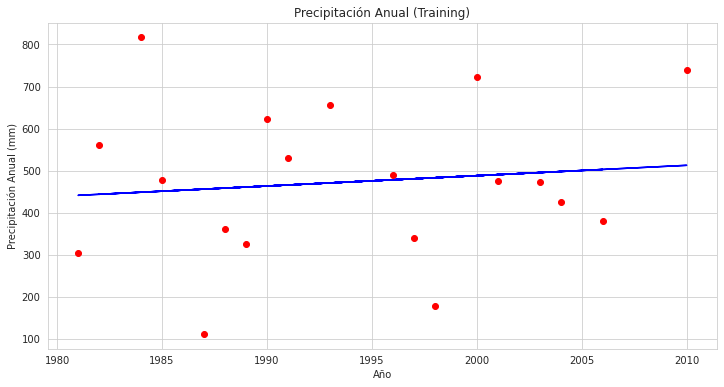

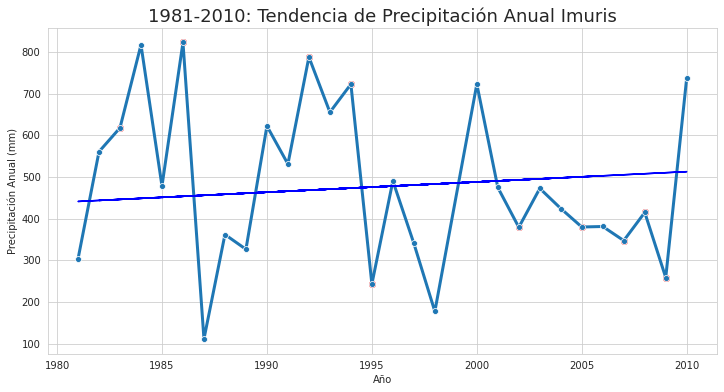

Pendiente de Ajuste. [2.46213554]


In [ ]:
# Regresión Lineal a la Precipitación Anual 

# importing the dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

X = Precip_Total.iloc[:,:-1].values  #independent variable array
y = Precip_Total.iloc[:,1].values  #dependent variable vector

sns.set_style('whitegrid')
plt.figure(figsize=(12,6))
 
# splitting the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1/3,random_state=0)
 
# fitting the regression model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train,y_train) #actually produces the linear eqn for the data
 
# predicting the test set results
y_pred = regressor.predict(X_test) 
y_pred
 
y_test
 
# visualizing the results
#plot for the TRAIN

#sns.lineplot('Año','NumDias', linewidth = 3.0, marker='o', data=Hot_days) 
plt.scatter(X_train, y_train, color='red') # plotting the observation line
plt.plot(X_train, regressor.predict(X_train), color='blue') # plotting the regression line
plt.title("Precipitación Anual (Training)") # stating the title of the graph
  
plt.xlabel("Año") # adding the name of x-axis
plt.ylabel("Precipitación Anual (mm)") # adding the name of y-axis
plt.show() # specifies end of graph
 
#plot for the TEST

sns.set_style('whitegrid')
plt.figure(figsize=(12,6))

sns.lineplot('Año','Precip_tot', linewidth = 3.0, marker='o', data=Precip_Total)  
plt.scatter(X_test, y_test, color='red') 
plt.plot(X_train, regressor.predict(X_train), color='blue') # plotting the regression line
plt.title(Period+": Tendencia de Precipitación Anual "+CityName, fontsize=18)
  
plt.xlabel("Año") 
plt.ylabel("Precipitación Anual (mm)") 
plt.show() 

print('Pendiente de Ajuste.', regressor.coef_)


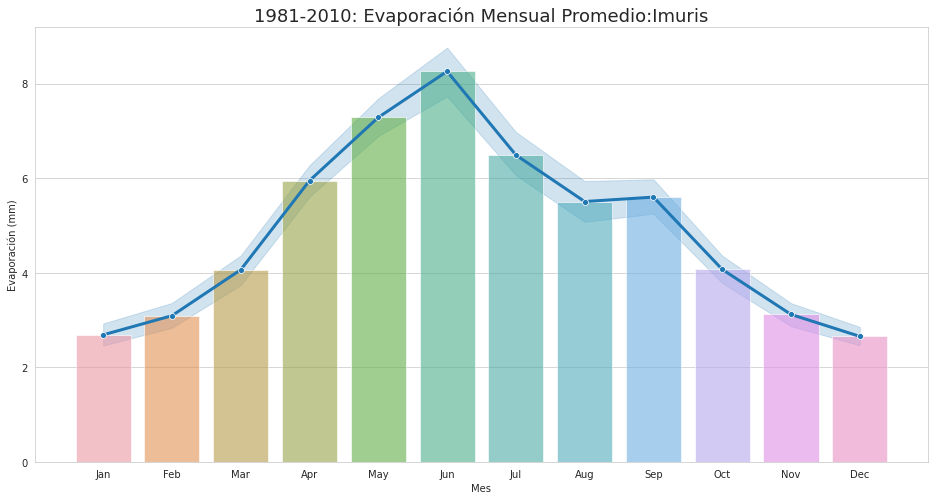

In [ ]:
# Skip

# Gráfica de Evaporación últimos 30 años
# Agrupado por Mes
sns.set_style('whitegrid')
plt.figure(figsize=(16,8))

g=sns.barplot(x='Mes', y='Evap', ci=None, data=df_81, alpha=0.6);
sns.lineplot('Mes', 'Evap', linewidth = 3.0, marker='o', data=df_81)
# Rotamos 45º los Años en el eje x para mejor lectura
#g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right');

plt.xlabel('Mes')
plt.ylabel('Evaporación (mm)')
plt.title(Period+': Evaporación Mensual Promedio:' + CityName, fontsize=18)

plt.show()


In [ ]:
# Skip

# Evaporación anual acumulada por año 

List_Yr = df_81['Año'].unique()

Evap_Total = pd.DataFrame(columns=['Año', 'Evap_tot'])

for yr in List_Yr:
    cum_sum=df_81.Evap.loc[(df_81['Año'] == yr)].sum();
    Evap_Total = Evap_Total.append({'Año': yr, 'Evap_tot': cum_sum}, ignore_index=True);
    
print(Evap_Total)

# Faltan muchos años de datos

       Año  Evap_tot
0   1981.0    1874.8
1   1982.0    1972.2
2   1983.0    1470.3
3   1984.0     134.6
4   1985.0       0.0
5   1986.0       0.0
6   1987.0       0.0
7   1988.0       0.0
8   1989.0       0.0
9   1990.0       0.0
10  1991.0       0.0
11  1992.0       0.0
12  1993.0       0.0
13  1994.0       0.0
14  1995.0       0.0
15  1996.0       0.0
16  1997.0       0.0
17  1998.0       0.0
18  1999.0       0.0
19  2000.0       0.0
20  2001.0       0.0
21  2002.0       0.0
22  2003.0       0.0
23  2004.0       0.0
24  2005.0       0.0
25  2006.0       0.0
26  2007.0       0.0
27  2008.0       0.0
28  2009.0       0.0
29  2010.0       0.0


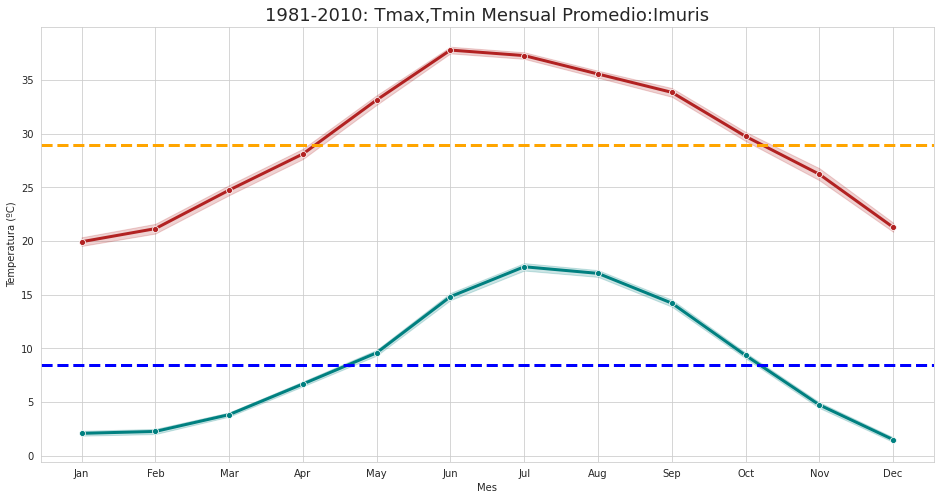

Tmax_prom Anual =  28.91728624535316
Tmin_prom Anual =  8.437744520386518


In [ ]:


# Gráfica de Temperatura últimos 30 años
# Agrupado por Mes
sns.set_style('whitegrid')
plt.figure(figsize=(16,8))

#g=sns.barplot(x='Mes', y='Tmax', ci=None, data=df_91);
sns.lineplot('Mes', 'Tmax', linewidth = 3.0, marker='o', data=df_81, color='firebrick')
sns.lineplot('Mes', 'Tmin', linewidth = 3.0, marker='o', data=df_81, color='teal')
plt.axhline(df_81['Tmax'].mean(), linewidth=3.0, color='orange', linestyle='--')
plt.axhline(df_81['Tmin'].mean(), linewidth=3.0, color='blue', linestyle='--')

# Rotamos 45º los Años en el eje x para mejor lectura
#g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right');

plt.xlabel('Mes')
plt.ylabel('Temperatura (ºC)')
plt.title(Period+': Tmax,Tmin Mensual Promedio:'+CityName, fontsize=18)

plt.show()
print('Tmax_prom Anual = ', df_81['Tmax'].mean())
print('Tmin_prom Anual = ', df_81['Tmin'].mean())


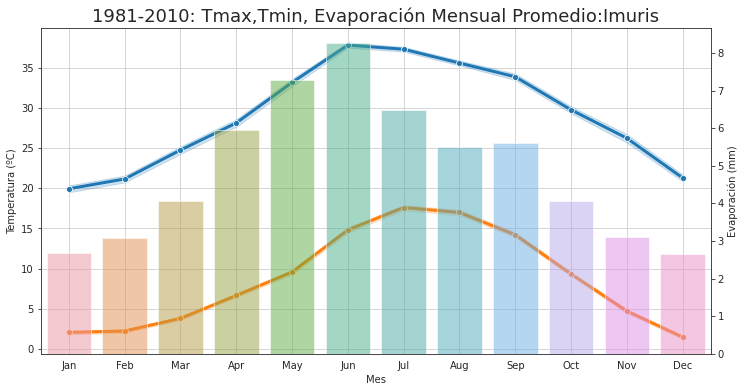

In [ ]:
# Skip 

# Gráfica de Precipitación últimos 30 años
# Agrupado por Mes

fig, ax = plt.subplots(figsize=(12,6))
sns.set_style('white')
#plt.figure(figsize=(16,8))
sns.lineplot('Mes', 'Tmax', linewidth = 3.0, marker='o', data=df_81)
sns.lineplot('Mes', 'Tmin', linewidth = 3.0, marker='o', data=df_81)
plt.ylabel('Temperatura (ºC)')
ax2 = ax.twinx()
sns.barplot(x='Mes', y='Evap', ci=None, alpha=0.5, data=df_81);
#    sns.plt.show()


plt.xlabel('Mes')
plt.ylabel('Evaporación (mm)')
plt.title(Period+': Tmax,Tmin, Evaporación Mensual Promedio:'+CityName, fontsize=18)

plt.show()



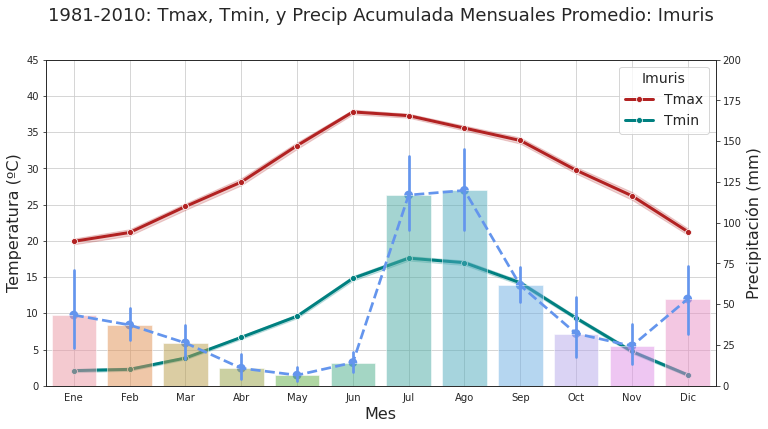

In [ ]:
# Ok!

# Gráfica de Precipitación últimos 30 años
# Agrupado por Mes

meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
             'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']  
fig, ax = plt.subplots(figsize=(12,6))
sns.set_style('white')
#plt.figure(figsize=(16,8))
ax.set_ylim(0, 45);
#ax.set_xticklabels(meses)
plt.grid()
sns.lineplot('Mes', 'Tmax', linewidth = 3.0, marker='o', data=df_81, label='Tmax', color='firebrick');
sns.lineplot('Mes', 'Tmin', linewidth = 3.0, marker='o', data=df_81, label='Tmin', color='teal');
plt.ylabel('Temperatura (ºC)', fontsize=16);
plt.xlabel('Mes', fontsize=16);
plt.legend(labels=["Tmax","Tmin"], title = CityName, fontsize = "14", title_fontsize = "14")

ax2 = ax.twinx()
ax2.set_ylim(0, 200)
#ax2.set_xticklabels(meses)
sns.pointplot(x='Month', y='Precip', alpha=0.5, marker='o', linestyles='--',linewidth = 3.0, data=df_Precip, color='cornflowerblue');
sns.barplot(x='Month', y='Precip', ci=None, alpha=0.5, data=df_Precip, label='Precip');
#    sns.plt.show()

plt.ylabel('Precipitación (mm)', fontsize=16);
plt.title(Period+': Tmax, Tmin, y Precip Acumulada Mensuales Promedio: '+CityName, fontsize=18, y=1.1);
ax2.set_xticklabels(meses, fontsize=14)
plt.show();



In [ ]:
# Días cálidos
df_81.Tmax.quantile([.85,0.86], interpolation='nearest')


0.85    38.0
0.86    39.0
Name: Tmax, dtype: float64

In [ ]:
# Número de días calientes Tmax > 40ºC

List_Yr = df_81['Año'].unique()

Hot_days = pd.DataFrame(columns=['Año', 'NumDias'])
T_hot = 40.0
for yr in List_Yr:
    knt=df_81.Tmax.loc[(df_81['Año'] == yr) & (df_81['Tmax'] >= T_hot)].count()
    Hot_days = Hot_days.append({'Año': yr, 'NumDias': pd.to_numeric(knt)}, ignore_index=True)
    #print(yr,knt)

print('Num. dias cálidos ', CityName)
Hot_days['NumDias'] = Hot_days['NumDias'].astype(float)
Hot_days.describe()


Num. dias cálidos  Imuris


,NumDias
count,29.000000
mean,34.275862
std,37.467030
min,0.000000
25%,2.000000
50%,15.000000
75%,70.000000
max,105.000000


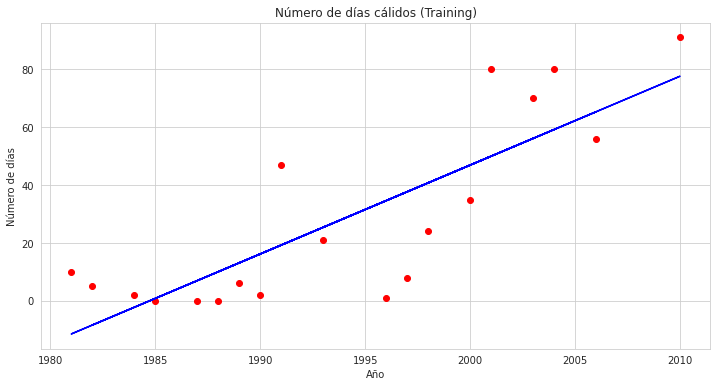

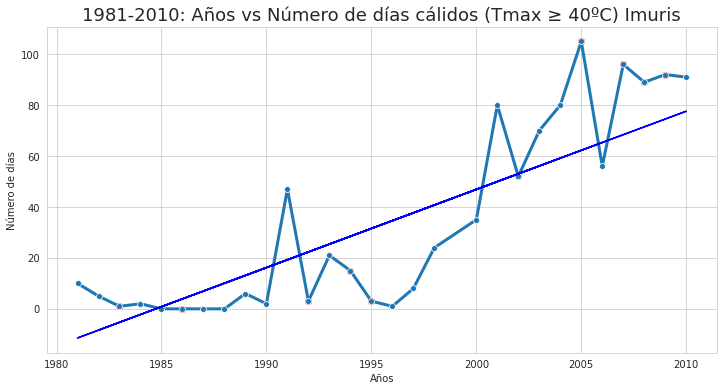

Pendiente de Ajuste. [3.07054898]


In [ ]:

# importing the dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.figure(figsize=(12,6))

X = Hot_days.iloc[:,:-1].values  #independent variable array
y = Hot_days.iloc[:,1].values  #dependent variable vector
 
# splitting the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1/3,random_state=0)
 
# fitting the regression model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train,y_train) #actually produces the linear eqn for the data
 
# predicting the test set results
y_pred = regressor.predict(X_test) 
y_pred
 
y_test
 
# visualizing the results
#plot for the TRAIN


#sns.lineplot('Año','NumDias', linewidth = 3.0, marker='o', data=Hot_days) 
plt.scatter(X_train, y_train, color='red') # plotting the observation line
plt.plot(X_train, regressor.predict(X_train), color='blue') # plotting the regression line
plt.title("Número de días cálidos (Training)") # stating the title of the graph
  
plt.xlabel("Año") # adding the name of x-axis
plt.ylabel("Número de días") # adding the name of y-axis
plt.show() # specifies end of graph
 
#plot for the TEST
sns.set_style('whitegrid')
plt.figure(figsize=(12,6))
ax.set_ylim(0,80)
sns.lineplot('Año','NumDias', linewidth = 3.0, marker='o', data=Hot_days)  
plt.scatter(X_test, y_test, color='red') 
plt.plot(X_train, regressor.predict(X_train), color='blue') # plotting the regression line
plt.title(Period+": Años vs Número de días cálidos (Tmax ≥ 40ºC) "+CityName, fontsize=18)

plt.xlabel("Años") 
plt.ylabel("Número de días") 
plt.show() 

print('Pendiente de Ajuste.', regressor.coef_)


In [ ]:
# Número de días fríos Tmin < 5ºC

List_Yr = df_81['Año'].unique()

Cold_days = pd.DataFrame(columns=['Año', 'NumDias'])
T_cold = 5.0
knt=0

for yr in List_Yr:
    knt=df_81.Tmax.loc[(df_81['Año'] == yr) & (df_81['Tmin'] <= T_cold)].count()
    Cold_days = Cold_days.append({'Año': yr, 'NumDias': pd.to_numeric(knt)}, ignore_index=True)
    #print(yr,knt)

print('Num. dias fríos ', CityName)
Cold_days['NumDias'] = Cold_days['NumDias'].astype(float)
Cold_days.describe()


Num. dias fríos  Imuris


,NumDias
count,29.000000
mean,118.103448
std,62.656857
min,0.000000
25%,87.000000
50%,106.000000
75%,138.000000
max,304.000000


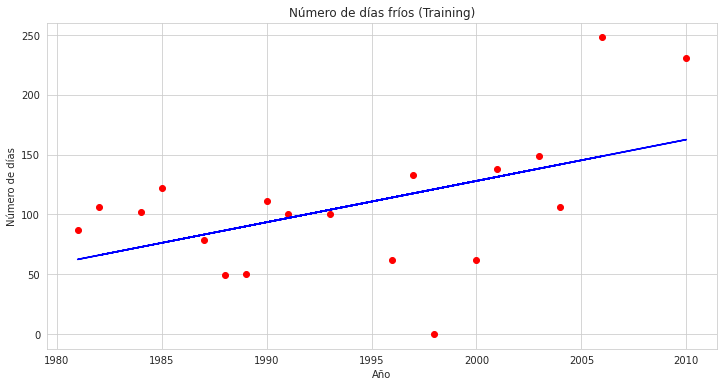

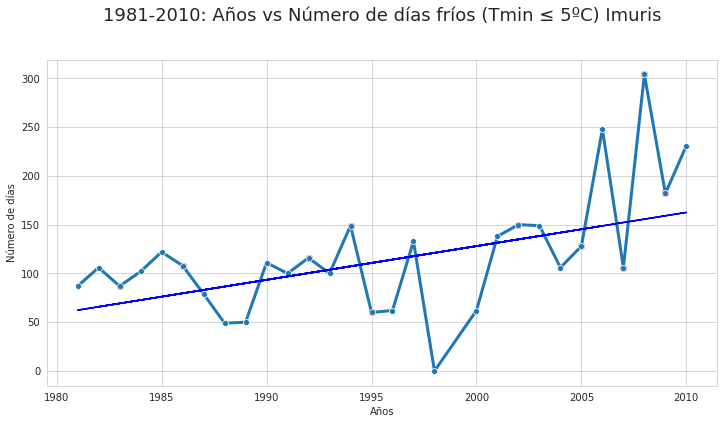

Pendiente de Ajuste. [3.45606578]


In [ ]:
# Plot regression
sns.set_style('whitegrid')
plt.figure(figsize=(12,6))

X = Cold_days.iloc[:,:-1].values  #independent variable array
y = Cold_days.iloc[:,1].values  #dependent variable vector
 
# splitting the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1/3,random_state=0)
 
# fitting the regression model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train,y_train) #actually produces the linear eqn for the data
 
# predicting the test set results
y_pred = regressor.predict(X_test) 
y_pred
 
y_test
 
# visualizing the results
#plot for the TRAIN


#sns.lineplot('Año','NumDias', linewidth = 3.0, marker='o', data=Hot_days) 
plt.scatter(X_train, y_train, color='red') # plotting the observation line
plt.plot(X_train, regressor.predict(X_train), color='blue') # plotting the regression line
plt.title("Número de días fríos (Training)") # stating the title of the graph
  
plt.xlabel("Año") # adding the name of x-axis
plt.ylabel("Número de días") # adding the name of y-axis
plt.show() # specifies end of graph
 
#plot for the TEST
sns.set_style('whitegrid')
plt.figure(figsize=(12,6))
ax.set_ylim(0,80)
sns.lineplot('Año','NumDias', linewidth = 3.0, marker='o', data=Cold_days)  
plt.scatter(X_test, y_test, color='red') 
plt.plot(X_train, regressor.predict(X_train), color='blue') # plotting the regression line
plt.title(Period+": Años vs Número de días fríos (Tmin ≤ 5ºC) "+CityName, fontsize=18, y=1.1)

plt.xlabel("Años") 
plt.ylabel("Número de días") 
plt.show() 

print('Pendiente de Ajuste.', regressor.coef_)


In [ ]:
# Número de días con Precip Precip > 1mm

Precip0 = 1.0

List_Yr = df_81['Año'].unique()

Precip_days = pd.DataFrame(columns=['Año', 'NumDias'])

for yr in List_Yr:
    knt=df_81.Precip.loc[(df_81['Año'] == yr) & (df_81['Precip'] >= Precip0)].count()
    Precip_days = Precip_days.append({'Año': yr, 'NumDias': pd.to_numeric(knt)}, ignore_index=True)
    #print(yr,knt)

print('Num. Dias Precip', CityName)
Precip_days['NumDias'] = Precip_days['NumDias'].astype(float)
Precip_days.describe()


Num. Dias Precip SLRC


,NumDias
count,30.000000
mean,6.100000
std,8.441891
min,0.000000
25%,2.000000
50%,4.000000
75%,8.500000
max,46.000000


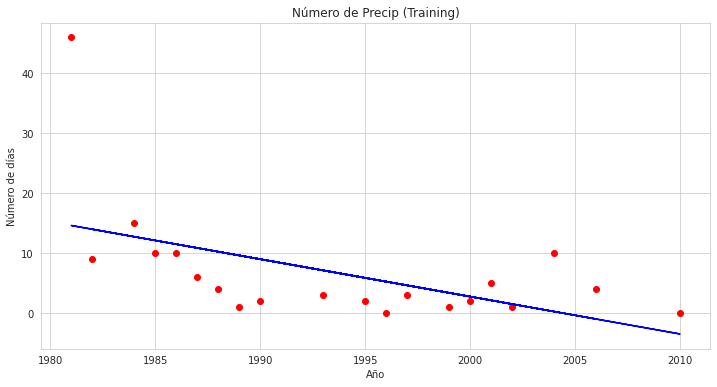

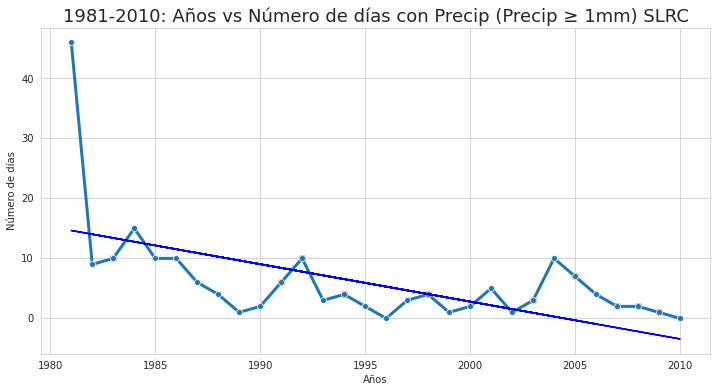

Pendiente de Ajuste. [-0.62365591]


In [ ]:

# importing the dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.figure(figsize=(12,6))

X = Precip_days.iloc[:,:-1].values  #independent variable array
y = Precip_days.iloc[:,1].values  #dependent variable vector
 
# splitting the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1/3,random_state=0)
 
# fitting the regression model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train,y_train) #actually produces the linear eqn for the data
 
# predicting the test set results
y_pred = regressor.predict(X_test) 
y_pred
 
y_test
 
# visualizing the results
#plot for the TRAIN


#sns.lineplot('Año','NumDias', linewidth = 3.0, marker='o', data=Hot_days) 
plt.scatter(X_train, y_train, color='red') # plotting the observation line
plt.plot(X_train, regressor.predict(X_train), color='blue') # plotting the regression line
plt.title("Número de Precip (Training)") # stating the title of the graph
  
plt.xlabel("Año") # adding the name of x-axis
plt.ylabel("Número de días") # adding the name of y-axis
plt.show() # specifies end of graph
 
#plot for the TEST
sns.set_style('whitegrid')
plt.figure(figsize=(12,6))
ax.set_ylim(0,80)
sns.lineplot('Año','NumDias', linewidth = 3.0, marker='o', data=Precip_days)  
plt.scatter(X_test, y_test, color='red') 
plt.plot(X_train, regressor.predict(X_train), color='blue') # plotting the regression line
plt.title(Period+": Años vs Número de días con Precip (Precip ≥ 1mm) "+CityName, fontsize=18)

plt.xlabel("Años") 
plt.ylabel("Número de días") 
plt.show() 

print('Pendiente de Ajuste.', regressor.coef_)


In [ ]:
df_81.Tmin.quantile([.85,0.86], interpolation='nearest')


0.85    23.5
0.86    23.5
Name: Tmin, dtype: float64

In [ ]:
df_81.Tmin.quantile([.85])

0.85    23.5
Name: Tmin, dtype: float64

In [ ]:
# Número de días consecutivos Tmin > 24ºC
T_min = 17.0

List_Yr = df_81['Año'].unique()

HeatWaves_knt = pd.DataFrame(columns=['Año', 'NumOlasCalor'])

for yr in List_Yr: 
    knt=df_81.Tmax.loc[(df_81['Año'] == yr) & (df_81['Tmin'] >= T_min)].count()
    HeatWaves_knt = HeatWaves_knt.append({'Año': yr, 'NumOlasCalor': pd.to_numeric(knt)}, ignore_index=True)
    print(yr,knt)


1986 140
1987 157
1988 139
1989 150
1990 134
1991 125
1992 156
1993 174
1994 151
1995 131
1996 152
1997 158
1998 140
1999 140
2000 146
2001 161
2002 134
2003 130
2004 159
2005 173
2006 142
2007 178
2008 26
2009 163
2010 150


In [ ]:
df_test = df_81.copy()
df_test['Juliano'] = df_81['Fecha'].dt.strftime('%Y%j')
df_test.head()


,Fecha,Precip,Evap,Tmax,Tmin,Año,Mes,DiaJuliano,Juliano
4884,1981-01-01,0.0,2.9,28.0,8.0,1981,Jan,1981001,1981001
4885,1981-01-02,0.0,2.0,30.0,9.0,1981,Jan,1981002,1981002
4886,1981-01-03,0.0,2.9,29.0,10.0,1981,Jan,1981003,1981003
4887,1981-01-04,0.0,2.4,29.0,11.0,1981,Jan,1981004,1981004
4888,1981-01-05,24.0,1.8,26.0,12.0,1981,Jan,1981005,1981005


In [ ]:
!pip install standard-precip
from standard_precip.spi import SPI
from standard_precip.utils import plot_index


ModuleNotFoundError: ignored

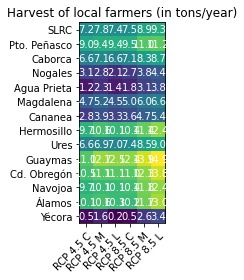

In [ ]:
# February Tmin 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

vegetables = ["SLRC", "Pto. Peñasco", "Caborca", "Nogales",
              "Agua Prieta", "Magdalena", "Cananea", "Hermosillo", "Ures", 
              "Guaymas", "Cd. Obregón","Navojoa", "Álamos", "Yécora"]
farmers= ["RCP 4.5 C", "RCP 4.5 M", "RCP 4.5 L",
           "RCP 8.5 C", "RCP 8.5 M", "RCP 8.5 L"]

harvest0 = np.array([[7.2,9.0,6.6, 3.1, 1.2, 4.7, 2.8, 9.7,6.6,11.0,10.5,9.7,10.1,0.5],
                    [7.8,9.4,7.1,2.8,2.3,5.2,3.9,10.6,6.9,12.7,11.1,10.1,10.6,1.6],
                    [7.4,9.4,6.6,2.1,1.4,4.5,3.3,10.1,7.0,12.5,11.1,10.1,10.3,0.2],
                    [7.5,9.5,7.1,2.7,1.8,5.0,3.6,10.4,7.4,12.4,11.0,10.4,10.2,0.5],
                    [8.9,11.0,8.3,3.8,3.1,6.0,4.7,11.4,8.5,13.9,12.3,11.8,11.7,2.6],
                    [9.3,11.2,8.7,4.4,3.8,6.6,5.4,12.4,9.0,14.9,13.8,12.4,13.0,3.4]])
harvest=harvest0.T

fig, ax = plt.subplots()
im = ax.imshow(harvest)

# We want to show all ticks...
ax.set_xticks(np.arange(len(farmers)))
ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
ax.set_xticklabels(farmers)
ax.set_yticklabels(vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()


In [ ]:
len(farmers)

6

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    # Turn spines off and create white grid.
    #ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


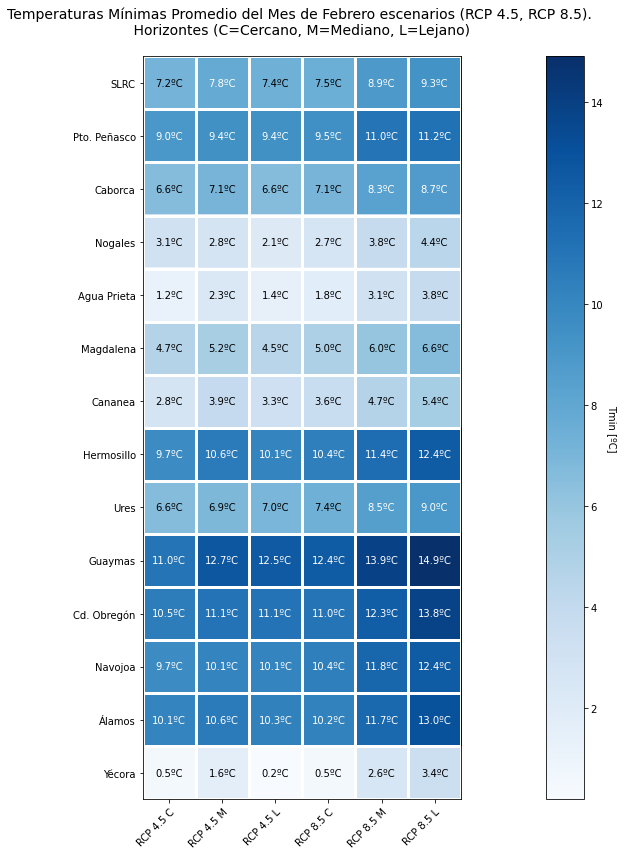

In [ ]:
fig, ax = plt.subplots(figsize=(24,12))

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax, cmap="Blues", cbarlabel="Tmin [ºC]")
texts = annotate_heatmap(im, valfmt="{x:.1f}ºC")
ax.set_title("Temperaturas Mínimas Promedio del Mes de Febrero escenarios (RCP 4.5, RCP 8.5). \n Horizontes (C=Cercano, M=Mediano, L=Lejano) \n", fontsize='14' )
fig.tight_layout()
plt.show()


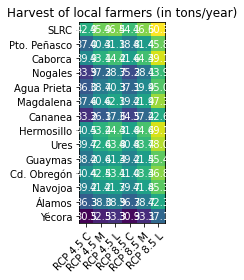

In [ ]:
# August Tmax 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

vegetables = ["SLRC", "Pto. Peñasco", "Caborca", "Nogales",
              "Agua Prieta", "Magdalena", "Cananea", "Hermosillo", "Ures", 
              "Guaymas", "Cd. Obregón","Navojoa", "Álamos", "Yécora"]
farmers = ["RCP 4.5 C", "RCP 4.5 M", "RCP 4.5 L",
           "RCP 8.5 C", "RCP 8.5 M", "RCP 8.5 L"]

harvest0 = np.array([[42.9,37.0,39.9,33.9,36.0,37.6,33.2,40.5,39.7,38.2,40.4,39.2,36.3,30.5],
                    [45.9,40.3,43.1,37.2,38.7,40.6,36.1,43.2,42.6,40.6,42.5,41.2,38.0,32.5],
                    [46.5,41.1,44.2,38.7,40.3,42.1,37.6,44.3,43.8,41.4,43.1,41.7,38.9,33.3],
                    [44.1,38.8,41.6,35.2,37.1,39.2,34.5,41.8,40.8,39.2,41.0,39.7,36.7,30.9],
                    [46.6,41.4,44.3,38.1,39.9,41.9,37.2,44.6,43.7,41.5,43.3,41.8,38.7,33.1],
                    [50.3,45.8,49.1,43.9,45.0,47.3,42.6,49.1,48.0,45.4,46.8,45.3,42.3,37.1]])

harvest=harvest0.T 

fig, ax = plt.subplots()
im = ax.imshow(harvest)

# We want to show all ticks...
ax.set_xticks(np.arange(len(farmers)))
ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
ax.set_xticklabels(farmers)
ax.set_yticklabels(vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()


In [ ]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    # Turn spines off and create white grid.
    #ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


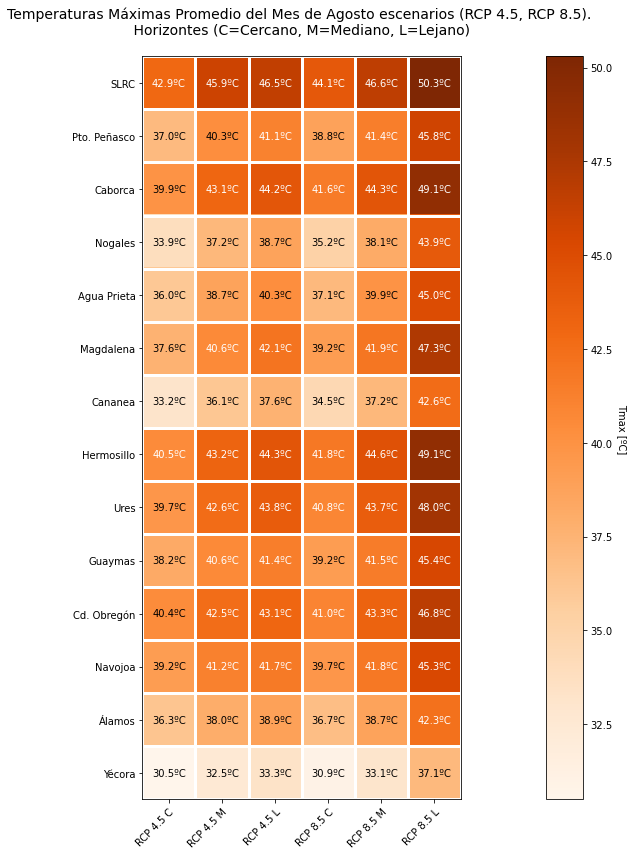

In [ ]:
fig, ax = plt.subplots(figsize=(24,12))

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax, cmap="Oranges", cbarlabel="Tmax [ºC]")
texts = annotate_heatmap(im, valfmt="{x:.1f}ºC")
ax.set_title("Temperaturas Máximas Promedio del Mes de Agosto escenarios (RCP 4.5, RCP 8.5). \n Horizontes (C=Cercano, M=Mediano, L=Lejano) \n", fontsize='14' )
fig.tight_layout()
plt.show()


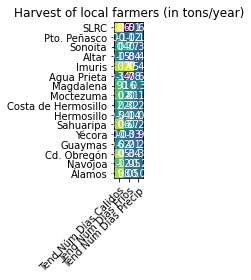

In [ ]:
# Trends (jun 13, 2021)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

farmers = ["Tend Núm Días Calidos", "Tend Núm Días Fríos", "Tend Núm Días Precip"]

vegetables = ["SLRC", "Pto. Peñasco", "Sonoita", "Altar", "Imuris",
              "Agua Prieta", "Magdalena", "Moctezuma", "Costa de Hermosillo", "Hermosillo", "Sahuaripa", "Yécora",
              "Guaymas", "Cd. Obregón","Navojoa", "Álamos"]


harvest = np.array([[3.86,-2.51,-0.62],
                    [0.1,-0.12,-0.11],
                    [1.04,0.77,-0.38],
                    [0.15,-0.84,-0.43],
                    [3.07,3.45,-0.49],
                    [0.34, -1.78, -0.65],
                    [1.91,0.60,0.30],
                    [2.02,0.81,-0.16],
                    [1.22,0.32,-0.23],
                    [0.54,-0.14,-0.09],
                    [3.06,0.57,-0.23],
                    [0.0,-0.33,-0.91],
                    [0.62,-0.21,-0.28],
                    [3.05,-0.34,-0.32],
                    [2.12,-0.05,-0.2],
                    [2.98,0.05,0.0]
                    ])


fig, ax = plt.subplots()
im = ax.imshow(harvest)

# We want to show all ticks...
ax.set_xticks(np.arange(len(farmers)))
ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
ax.set_xticklabels(farmers)
ax.set_yticklabels(vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()


In [ ]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    # Turn spines off and create white grid.
    #ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "navy"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


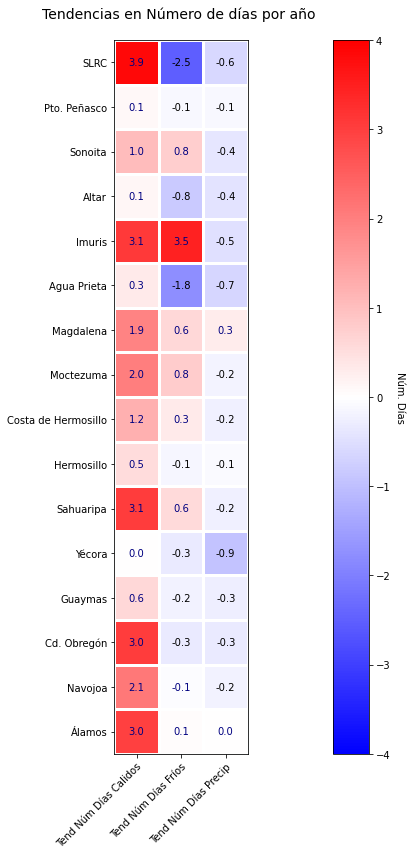

In [ ]:
fig, ax = plt.subplots(figsize=(24,12))

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax, cmap="bwr", cbarlabel="Núm. Días", vmin=-4, vmax=4)
texts = annotate_heatmap(im, valfmt="{x:.1f}")
ax.set_title("Tendencias en Número de días por año \n", fontsize='14' )
#sns.set(font_scale=1.5) # font size 2

fig.tight_layout()
plt.show()


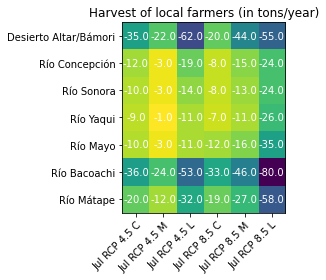

In [ ]:
# Cambios % precipitación Mes de Julio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

farmers = ["Jul RCP 4.5 C", "Jul RCP 4.5 M", "Jul RCP 4.5 L", "Jul RCP 8.5 C", "Jul RCP 8.5 M", "Jul RCP 8.5 L"]

vegetables = ["Desierto Altar/Bámori", "Río Concepción", "Río Sonora", "Río Yaqui", "Río Mayo", "Río Bacoachi", "Río Mátape"]


harvest = np.array([[-35.,-22.,-62., -20., -44., -55.],
                    [-12., -3., -19., -8., -15., -24.],
                    [-10., -3., -14., -8.,-13.,-24.],
                    [-9., -1., -11., -7., -11., -26.],
                    [-10.,-3.,-11., -12., -16., -35.],
                    [-36.,-24.,-53., -33., -46., -80.],
                    [-20, -12, -32, -19, -27, -58]
                    ])

fig, ax = plt.subplots()
im = ax.imshow(harvest)

# We want to show all ticks...
ax.set_xticks(np.arange(len(farmers)))
ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
ax.set_xticklabels(farmers)
ax.set_yticklabels(vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()


In [ ]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    # Turn spines off and create white grid.
    #ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("white", "black"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


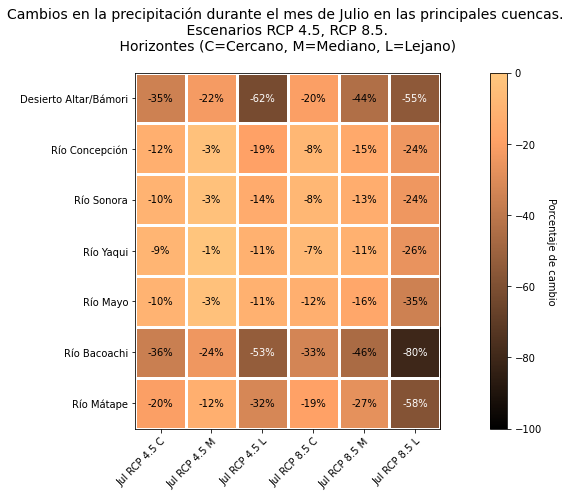

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax, cmap="copper", cbarlabel="Porcentaje de cambio", vmin=-100, vmax=0)
texts = annotate_heatmap(im, valfmt="{x:.0f}%")
ax.set_title("Cambios en la precipitación durante el mes de Julio en las principales cuencas. \n Escenarios RCP 4.5, RCP 8.5. \n Horizontes (C=Cercano, M=Mediano, L=Lejano) \n", fontsize='14' )
#sns.set(font_scale=1.5) # font size 2

fig.tight_layout()
plt.show()


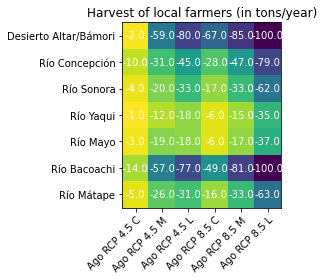

In [ ]:
# Cambios % precipitación Agosto
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

farmers = ["Ago RCP 4.5 C", "Ago RCP 4.5 M", "Ago RCP 4.5 L", "Ago RCP 8.5 C", "Ago RCP 8.5 M", "Ago RCP 8.5 L"]

vegetables = ["Desierto Altar/Bámori", "Río Concepción", "Río Sonora", "Río Yaqui", "Río Mayo", "Río Bacoachi", "Río Mátape"]


harvest = np.array([[ -2., -59., -80., -67., -85., -100.],
                    [-10.,-31.,-45., -28.,-47.,-79.],
                    [-4.,-20.,-33., -17., -33., -62.],
                    [-1.,-12.,-18.,-6., -15., -35.],
                    [-3., -19.,-18.,-6., -17., -37.],
                    [-14, -57, -77,-49, -81, -100],
                    [-5, -26, -31, -16, -33, -63]
                    ])

fig, ax = plt.subplots()
im = ax.imshow(harvest)

# We want to show all ticks...
ax.set_xticks(np.arange(len(farmers)))
ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
ax.set_xticklabels(farmers)
ax.set_yticklabels(vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()


In [ ]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    # Turn spines off and create white grid.
    #ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("white", "black"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


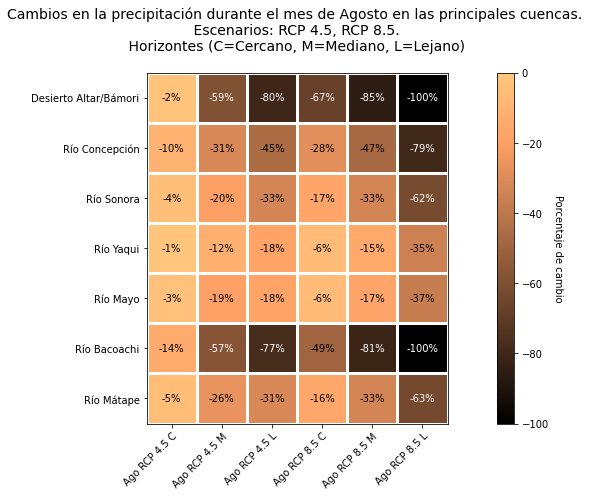

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax, cmap="copper", cbarlabel="Porcentaje de cambio", vmin=-100, vmax=0)
texts = annotate_heatmap(im, valfmt="{x:.0f}%")
ax.set_title("Cambios en la precipitación durante el mes de Agosto en las principales cuencas. \n Escenarios: RCP 4.5, RCP 8.5. \n Horizontes (C=Cercano, M=Mediano, L=Lejano) \n", fontsize='14' )
#sns.set(font_scale=1.5) # font size 2

fig.tight_layout()
plt.show()
